In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

# Paths
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"
test_img_dir = Path("/home/paster/LMY/data/general/split/test/images")
test_mask_dir = Path("/home/paster/LMY/data/general/split/test/mask")

# Load model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)




/home/paster/miniconda3/envs/segformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Collect image-mask pairs with non-empty masks
pairs = []
for mask_path in sorted(test_mask_dir.glob("*.png")):
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None or np.sum(mask) == 0:
        continue
    image_name = mask_path.name.replace(".png", ".tif")
    image_path = test_img_dir / image_name
    if image_path.exists():
        pairs.append((image_path, mask_path))

print(f"✅ Found {len(pairs)} non-empty test pairs.")



✅ Found 59 non-empty test pairs.


## Visualize a few predictions

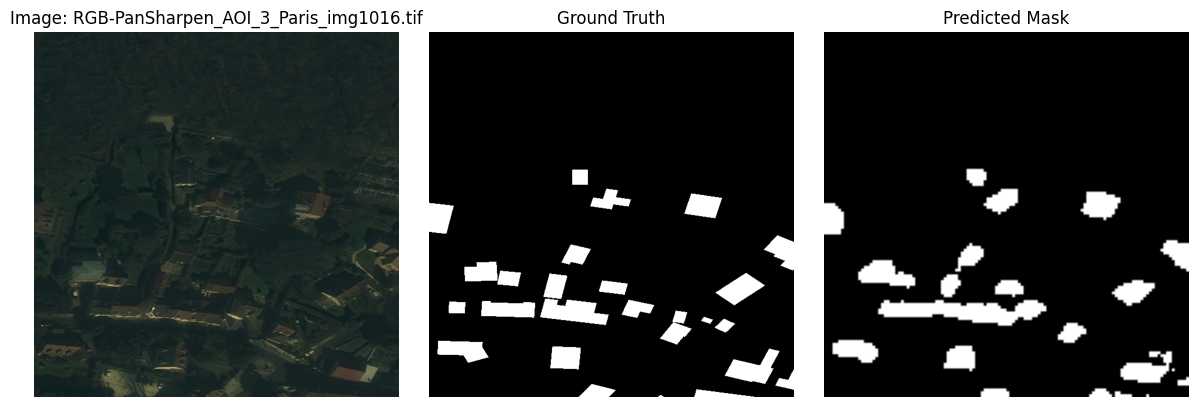

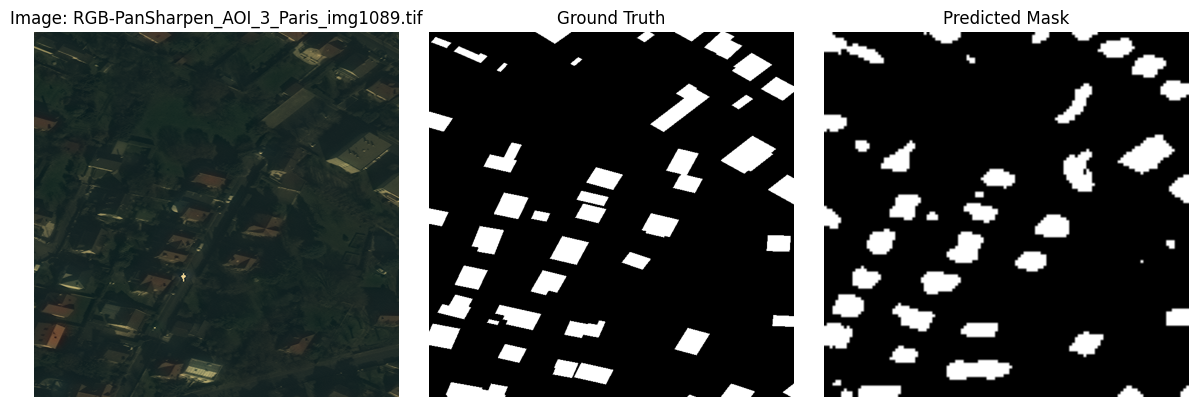

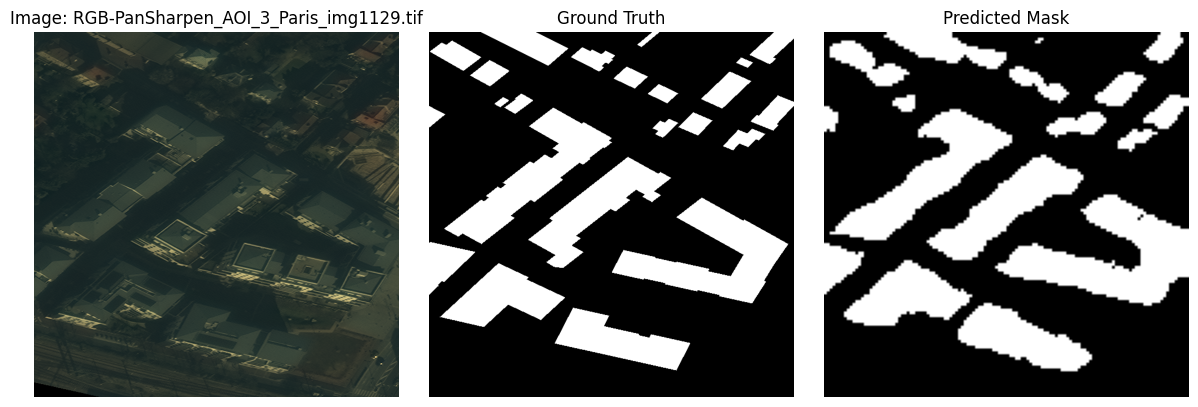

In [3]:
# Predict and visualize a few
n = min(3, len(pairs))
for i in range(n):
    img_path, mask_path = pairs[i]
    
    # Read image with rasterio
    with rasterio.open(img_path) as src:
        image = src.read([1, 2, 3])
        image = np.transpose(image, (1, 2, 0))
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        image_uint8 = (image * 255).astype(np.uint8)
    
    # Process and run model
    inputs = processor(images=image_uint8, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    pred_mask = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()

    # Read ground-truth mask
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    # Show side by side
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Image: {img_path.name}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

## All images

In [4]:
import os
import cv2
import torch
import rasterio
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Results ===
results = []

# === Evaluation Loop ===
for split in splits:
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"

    image_paths = sorted(img_dir.glob("*.tif"))
    y_true_all = []
    y_pred_all = []
    count = 0

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue
        count += 1

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        # Read ground truth
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        gt_mask = (gt_mask > 0).astype(np.uint8)

        # Resize to match predicted mask shape
        gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Flatten and store
        y_true_all.extend(gt_mask_resized.flatten().tolist())
        y_pred_all.extend(pred_mask_bin.flatten().tolist())

    # Compute metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    iou = jaccard_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    results.append({
        "split": split,
        "samples": count,
        "accuracy": acc,
        "iou": iou,
        "f1": f1,
        "precision": prec,
        "recall": rec,
    })


In [5]:
for res in results:
    print(f"   Split: {res['split']} | Samples: {res['samples']}")
    print(f"   Accuracy:  {res['accuracy']:.4f}")
    print(f"   IoU:       {res['iou']:.4f}")
    print(f"   F1 Score:  {res['f1']:.4f}")
    print(f"   Precision: {res['precision']:.4f}")
    print(f"   Recall:    {res['recall']:.4f}\n")


   Split: train | Samples: 918
   Accuracy:  0.9775
   IoU:       0.7223
   F1 Score:  0.8388
   Precision: 0.8297
   Recall:    0.8481

   Split: val | Samples: 114
   Accuracy:  0.9714
   IoU:       0.6953
   F1 Score:  0.8203
   Precision: 0.8040
   Recall:    0.8372

   Split: test | Samples: 116
   Accuracy:  0.9766
   IoU:       0.6805
   F1 Score:  0.8099
   Precision: 0.7983
   Recall:    0.8218



## Images with buildings only

In [6]:
import os
import cv2
import torch
import rasterio
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Results ===
results = []

# === Evaluation Loop ===
for split in splits:
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"

    image_paths = sorted(img_dir.glob("*.tif"))
    y_true_all = []
    y_pred_all = []
    count = 0

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue

        # Read ground truth mask first to filter
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if gt_mask is None or np.sum(gt_mask) == 0:
            continue  # Skip empty masks (no buildings)

        count += 1

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        gt_mask = (gt_mask > 0).astype(np.uint8)
        gt_mask_resized = cv2.resize(gt_mask, (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

        y_true_all.extend(gt_mask_resized.flatten().tolist())
        y_pred_all.extend(pred_mask_bin.flatten().tolist())

    # Compute metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    iou = jaccard_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    results.append({
        "split": split,
        "samples": count,
        "accuracy": acc,
        "iou": iou,
        "f1": f1,
        "precision": prec,
        "recall": rec,
    })

# Print results
for r in results:
    print(f"Split: {r['split']} | Samples: {r['samples']}")
    print(f"  Accuracy:  {r['accuracy']:.4f}")
    print(f"  IoU:       {r['iou']:.4f}")
    print(f"  F1 Score:  {r['f1']:.4f}")
    print(f"  Precision: {r['precision']:.4f}")
    print(f"  Recall:    {r['recall']:.4f}")
    print()


Split: train | Samples: 508
  Accuracy:  0.9593
  IoU:       0.7223
  F1 Score:  0.8388
  Precision: 0.8297
  Recall:    0.8481

Split: val | Samples: 66
  Accuracy:  0.9512
  IoU:       0.6977
  F1 Score:  0.8220
  Precision: 0.8072
  Recall:    0.8372

Split: test | Samples: 59
  Accuracy:  0.9543
  IoU:       0.6816
  F1 Score:  0.8107
  Precision: 0.7998
  Recall:    0.8218



## Images with buildings only

In [8]:
import os
import cv2
import torch
import rasterio
import numpy as np
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === Paths ===
base_path = Path("/home/paster/LMY/data/general/split")
splits = ["train", "val", "test"]
checkpoint_path = "/home/paster/LMY/segformer_output/checkpoint-13770"

# === Load model and processor ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = SegformerImageProcessor(do_resize=True, size=(512, 512), do_normalize=True, reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(checkpoint_path).to(device)
model.eval()

# === Evaluation Results ===
results = []

# === Evaluation Loop ===
for split in splits:
    img_dir = base_path / split / "images"
    mask_dir = base_path / split / "mask"

    image_paths = sorted(img_dir.glob("*.tif"))
    y_true_all = []
    y_pred_all = []
    count = 0

    for img_path in image_paths:
        mask_path = mask_dir / img_path.name.replace(".tif", ".png")
        if not mask_path.exists():
            continue

        # Read ground truth to check if there's any building (positive class)
        gt_mask_check = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if gt_mask_check is None or np.sum(gt_mask_check) == 0:
            continue  # skip background-only images

        count += 1

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read([1, 2, 3])
            image = np.transpose(image, (1, 2, 0))
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)
            image_uint8 = (image * 255).astype(np.uint8)

        inputs = processor(images=image_uint8, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predicted_mask = logits.argmax(dim=1)[0].cpu().numpy()
            pred_mask_bin = (predicted_mask > 0).astype(np.uint8)

        # Read and binarize ground truth
        gt_mask = (gt_mask_check > 0).astype(np.uint8)

        # Resize to match predicted mask shape
        gt_mask_resized = cv2.resize(gt_mask, (pred_mask_bin.shape[1], pred_mask_bin.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Flatten and store
        y_true_all.extend(gt_mask_resized.flatten().tolist())
        y_pred_all.extend(pred_mask_bin.flatten().tolist())

    # Compute metrics
    acc = accuracy_score(y_true_all, y_pred_all)  # Same as pixel accuracy
    iou = jaccard_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all)
    prec = precision_score(y_true_all, y_pred_all)
    rec = recall_score(y_true_all, y_pred_all)

    results.append({
        "split": split,
        "samples": count,
        "pixel_accuracy": acc,
        "iou": iou,
        "f1": f1,
        "precision": prec,
        "recall": rec,
    })

# Print results
for r in results:
    print(f"\nSplit: {r['split']} | Samples: {r['samples']}")
    print(f"  Pixel Accuracy: {r['pixel_accuracy']:.4f}")
    print(f"  IoU:            {r['iou']:.4f}")
    print(f"  F1 Score:       {r['f1']:.4f}")
    print(f"  Precision:      {r['precision']:.4f}")
    print(f"  Recall:         {r['recall']:.4f}")



Split: train | Samples: 508
  Pixel Accuracy: 0.9593
  IoU:            0.7223
  F1 Score:       0.8388
  Precision:      0.8297
  Recall:         0.8481

Split: val | Samples: 66
  Pixel Accuracy: 0.9512
  IoU:            0.6977
  F1 Score:       0.8220
  Precision:      0.8072
  Recall:         0.8372

Split: test | Samples: 59
  Pixel Accuracy: 0.9543
  IoU:            0.6816
  F1 Score:       0.8107
  Precision:      0.7998
  Recall:         0.8218
